# cphonon function
### Authors
Written by Andris Potrebko, that smiling guy from Latvia in *2019*. Thanks for the theoretical support by Andreas Wacker\
Much inspired by a matlab code which was written by Anders Blom in *1999* and then improved by Björn Samuelsson, *2000*

* The first part is the *actual calculation part*, second one is the *user interface* part. In the first part the eigenfrequencies *omega*, k vectors (multiplied with the lattice seperation *a*) *Ka* and eigenvectors *V* are calculated and plotted. It is defined though functions, each of which are doing a specific part and afterwards all of them are continiouslly being executed in the GUI part.

* If you want only to check what is here, go step by step, read the written explanations and execute cell by cell *ctrl+enter*. Feel free to uncomment the cells containing only outputs e.g cell containing only *#A* and check how the output looks like.

### So, we begin with importing some important libraries

In [1]:
%matplotlib inline 
%matplotlib notebook 
# ^^ Will display figures in the same cell as the code is ^^
from matplotlib import pyplot as plt

from scipy.sparse import diags
import numpy as np
from scipy.linalg import eig
#import ipywidgets as widgets
#from ipywidgets import interact, interactive
#from IPython.display import display    #Java - not there anymore for running cells from widgits
from math import log

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#from IPython.utils.capture import capture_output #To suppress the output at some points

### Define some initial values

* bc - boundary conditions if bc=0 - peridoc b.c; if bc=1 - fixed ends; if bc=2 - free ends.
* N - number of atoms; M1/ M2 - masses of the first/second atom in the diatomic chane. When M1=M2, then program considers monoatomic chane.
* gamma - force constant
* imp_enabled - if 1 then enabled, if 0, then not enabled
* Nimp, Mimp - atom number at which the impurity is at, mass of the impurity\
You shouldn't begin with N=2 and bc=1. Otherwise at some points it will give errors because *ka* is going to be a null vector, which I haven't dealt with.

In [2]:
N = 10
M1 = 30
M2 = 30
gamma = 35
imp_enabled = 0
Nimp = 5
Mimp = 25
bc = 0

Create force matrix, with 2 on the diagonal and -1 on each side


In [3]:
def CreateForceMatrix(N):
    tmp1 = [-1]*(N-1)
    tmp2 = [2]*N
    diagonals = [tmp1, tmp2, tmp1]  # the diagonals of the force matrix
    A = diags(diagonals, [-1, 0, 1]).todense()
    return(A)
A = CreateForceMatrix(N)

In [4]:
#A

Update the force matrix considering all boundary conditions

In [5]:
def ForceMatrixBoundaryCond(A, bc, N):
    if bc == 2:  # free ends
        A[0, 0] = 1
        A[N-1, N-1] = 1
    elif bc == 1:  # fixed ends
        A[0, 0] = - 2  # this will generate negative eigenvalues, to be removed below
        A[N-1, N-1] = - 2
        A[1, 0] = 0
        A[0, 1] = 0
        A[N - 2, N-1] = 0
        A[N-1, N - 2] = 0
    else:  # periodic boundary cond.
        A[0, N-1] += - 1  # The corner elements are -1 allways, except when N=2. then the atom
        A[N-1, 0] += - 1  # is connected to the other one in two ways. Thus the matrix element is =-2
    return(A)
A = ForceMatrixBoundaryCond(A, bc, N)

In [6]:
#A

Create mass matrix, take care of impurities

In [7]:
def CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled):
    Nimp = Nimp-1  # Python counts from 0
    B = np.zeros(shape=(N, N))  # diags([1]*N,0).todense()
    for i in range(N):
        if i % 2 == 0:  # if even
            B[i, i] = 1 / M1
        else:
            B[i, i] = 1 / M2

    if imp_enabled:
        B[Nimp, Nimp] = 1 / Mimp
    return(B)
B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)

In [8]:
# B

### Solve the eigenvalue equation
We get *omega* - eigenfrequencies and V - the vector of all displacements *u*

Set number of modes *Nmodes* for fixed b.c. this number will be reduced by 2 as we remove negative eigenvalues (Two of the atoms don't move)

In [9]:
def EigenEq(A, B, gamma, bc, N):
    A1 = np.dot(gamma*B, A)
    D, V = eig(A1)
    D = np.real(D)
    Nmodes = N
    # Find negative eigenvalues and remove corresponding eigenvectors/-values for fixed b.c
    if bc == 1:
        for k in range(2):
            neg = -1
            for i in range(Nmodes):
                if ((D[i] < -1e-06) & (neg == -1)):
                    neg = i
            D = np.concatenate([D[:(neg)], D[(neg+1):]])
            V = np.concatenate([V[:, :(neg)], V[:, (neg+1):]], axis=1)
            Nmodes = Nmodes - 1

    omega = np.sqrt(np.abs(D)) # Abs because D can be slightly negative ex. -6.10622664e-16
    
    # sort the eigenvalues and eigenmodes according to the eigenvalues
    ind = np.argsort(omega)
    omega = np.sort(omega)
    V = V[:, ind]

    return(omega, V)
omega, V = EigenEq(A, B, gamma, bc, N)

In [10]:
#omega
#V

### Discrete fourier transform
We use Fast fourier transform algorithm (*fft* function) to implement the discrete fourier transform.
* For the case of *fixed ends* boundary conditions the smallest wave possible can be a wave with the wavelength _2*(N-1)_ - our full system is half the wave length, the wave can be antisymetric with the wave outside. This is why when search the Fourier coefficients we extend the wave with its mirror image outside of our region, but at the end we cut the K interval because for *K>N+1* K is displaying the second Brilloin zone.
* For the case of *free ends* - the real periodicity is _2*N_. The cell goes from 0.5a to N+0.5a. At the end points the force is 0 => the deivative of the wave is zero.
* For periodic boundary conditions, the periodicity is *N* but seaching for k vectors  we cut, only up to *floor(N/2)*. Don't really get why it happens. But each frequency except zero is doubly degenerate with +K and -K solutions (moving in opposite directions), so when we look for K vectors, they will be in our normalised units 0, -1, 1, -2, 2, 3... What we will get from the fourier analysis, will only be the absolute values of these. So the K values will go from 0 to floor(N/2) and afterwards the peaks in the fourier spectrum will start to repeat, showing the next Brilloin zone. For other boundary conditions each K will be different in absolute values, the maximal value will correspond to Nmodes
* Karg is the phase of the obtained K. I basically use it only for the periodic case when distributing the K values

In [11]:
def FourierTransform(bc, V, N,omega):
    if bc == 2:  # free ended
        #wavemax = Nmodes
        Vplus=list(reversed(V[:,:])) #Add the mirror image - the other part of the system
        VFull=np.vstack((V,Vplus))
        Kk = np.fft.fft(VFull, 2*N, axis=0)
        Kk = Kk[:(N + 1), :N]    #Cut the first Brilluin zone
        #Ksq=np.imag(Kk)*np.imag(Kk)
        #Kargs = np.angle(Kk)
    elif bc == 1:  # for fixed ends imaginary part turns out to work better. Still don't get why
        #wavemax = Nmodes
        Vplus=list(reversed(V[:-1,:]*-1)) #Add the mirror image with the misus sign - the other part of the system
        VFull=np.vstack((V,Vplus))
        Kk = np.fft.fft(VFull, 2*(N - 1), axis=0)
        Kk = Kk[:(N ), :(N-2)]
        #Kargs=np.angle(Kk)
    else:  # periodic
        omega1=np.append(omega[1:],0)   #To search the two consecutive frequencies are the same
        oddDeg=np.abs(omega1-omega)<1e-06
        evenDeg=np.append(False,oddDeg[:-1])
        V=V.astype(complex)    #Make V matrix a complex matrix
        Vnew=np.zeros(shape=(N, N)).astype(complex)
        Vnew[:,oddDeg]=np.sqrt(1/2)*(V[:,oddDeg]+V[:,evenDeg]*1j) 
        V[:,evenDeg]=np.sqrt(1/2)*(V[:,oddDeg]-V[:,evenDeg]*1j)
        V[:,oddDeg]=Vnew[:,oddDeg]
        Kk = np.fft.fft(V, N, axis=0)
        if imp_enabled==1:  #
            Kk=Kk[:N//2+1,:]
        
#         wavemax = np.floor(N / 2)
#         Kk = np.fft.fft(V, N, axis=0)
#         Kk = Kk[:int(wavemax) + 1, :N]
#         Ksq = np.real(Kk*np.conj(Kk))  # can be a bit negative
#         Kargs = np.angle(Kk)

    #Previously was taken Ksq = np.imag(Kk)*np.imag(Kk) 
    #If we don't extend then the eigenmode is only positive and fourier transform fives K=0, which is not physical.
    #The previous matlab code solved this by taking the imag parts. I feels it more reasonable just to fix this manually
    #Check the commented out code bellow
    Ksq = np.real(Kk*np.conj(Kk))
    Ka = np.argmax(Ksq, axis=0)
    Karg=[0]*len(Ka)
    if bc==0: #Those K values which are above the first Brilluin zone put on the left branch
        index=Ka>np.floor(N/2)
        Ka[index]=Ka[index]-N
        
    #for (k, i) in zip(Ka, range(len(Ka))):
    #    Karg[i]=Kargs[k,i]
    # mx=np.max(Ksq,axis=0)#this one we don't need
    return(Ka, V)  # maybe Kk,
Ka, V = FourierTransform(bc, V, N,omega)

In [12]:
# Vplus=list(reversed(V[:-1,:]*-1)) #Add the mirror image with the misus sign - the other part of the system
# VFull=np.vstack((V,Vplus))
# Kk = np.fft.fft(VFull, 2*(N - 1), axis=0)
# Kk = Kk[:(N + 1), :(N-2)]
# Ksq = np.real(Kk*np.conj(Kk))

In [13]:
# plt.plot(Ksq[])

In [14]:
# Ksq1=np.imag(Kk)*np.imag(Kk)
# Ksq2=np.real(Kk*np.conj(Kk))

# plt.plot(Ksq1[:,0])
# plt.plot(Ksq2[:,0])

# #plt.plot(np.imag(Ksq1[:,1]))
#plt.plot(np.imag(Ksq2[:,1]))
#plt.plot(np.real(Ksq1[:,1]))
#plt.plot(np.real(Ksq2[:,1]))

In [15]:
Ka
omega

array([ 0,  1, -1, -2,  2, -3,  3, -4,  4,  5])

array([1.49011612e-08, 6.67553004e-01, 6.67553004e-01, 1.26976127e+00,
       1.26976127e+00, 1.74767645e+00, 1.74767645e+00, 2.05451689e+00,
       2.05451689e+00, 2.16024690e+00])

In [16]:
# if bc == 1:
#     Ka = Ka*np.pi / (N - 1)
# elif bc==0:
#     Ka = Ka*2*np.pi / N #*2 Remembering the cut we did at the Fourier transform
# elif bc==2:
#     Ka = Ka*np.pi / N

In [17]:
Ka

array([ 0,  1, -1, -2,  2, -3,  3, -4,  4,  5])

In [18]:
def CorrectOmega(Ka, omega, bc, M1, M2, N):
        # set correct magnitude of Ka
    if bc == 1:
        Ka = Ka*np.pi / (N - 1)
    elif bc==0:
        Ka = Ka*2*np.pi / N #*2 Remembering the cut we did at the Fourier transform
    elif bc==2:
        Ka = Ka*np.pi / N
    
    #Give the correct magnitude for the omega in THz. Now the omega is the real frequency, not the angular.
    #We keep the name omega.
    omega=omega*3.9057
    
    # The high Ka values () belong to
    if (M1 != M2):
        indx=np.abs(Ka) >= np.pi/2
        Ka[indx] = np.sign(Ka[indx])*(np.abs(Ka[indx]) - np.pi)

    # correct sign if the last Ka is on the right boundary to the left side (we define our interval of Ka: [-pi/a, pi/a) )
    if np.abs(Ka[-1] - np.pi) < 1e-06:
        Ka[-1] = - Ka[-1]
    return(omega, Ka)

omega, Ka = CorrectOmega(Ka, omega, bc, M1, M2, N)

### Bunch of boring but important manipulations with the results.
* For periodic boundary conditions we have doubly degenerate levels. For the degenerate levels: give the eigenmode with the smallest phase angle a plus sign and the other a minus sign. Afterwards we make the eigenmodes orthoganal. This will make them move into opposite directions (I guess)
* *Ka* values from the fft are only positive, the absolute values. For periodic b.c. we distribute them along the positive and negative branch. We do it also for other two boundary conditions even though there each wave is actually a combination of both *Ka* and *-Ka* (wave moving in the opposite directions), thus a standing wave
* Give the corect amplitude for *Ka*. So far they have been in values 1,2,..., but we want to them to be up to $Ka=k \cdot a=\frac{\pi}{2}$, where $a$ is the atomic distance


In [19]:
# # set Ka to the index of the biggest squared coefficient
# def CorrectOmega(Ka, Karg, V, omega, bc, M1, M2, N):
#     if len(Ka)==0:  # because in the case when bc=1 and N=2 gives an error
#         maxi = 0
#     else:
#         maxi = np.argmax(Ka)

#     if bc == 0:
#         for j in range(N-1):
#             if np.abs(omega[j] - omega[j + 1]) < 1e-06:  # if both omegas "almost" equal
#                 diff = Karg[j + 1] - Karg[j]
#                 if diff < - np.pi:
#                     diff = diff + 2*np.pi
#                 elif diff > np.pi:
#                     diff = diff - 2*np.pi
#                 # those where maxi+1 is even Ka will be -Ka, see below in this sec.
#                 if (diff > 0 != ( (maxi+j) % 2) ): #This means do only if both diff>0 and maxi+1 is even or both are not.
#                 # those where maxi+1 is even Ka will be -Ka, see below in this sec.
#                     V[:, j] = - V[:, j]
#                 # If the difference was pi/2 then changing the sign of one does not change the orthogonality
#                 # Otherwise make them both orthonormal (supposes normated vectors)
#                 if np.abs(np.abs(diff) - np.pi / 2) > 1e-06:
#                     V[:, j + 1] = V[:, j + 1] - V[:, j] * \
#                         np.dot(V[:, j + 1], V[:, j])
#                     V[:, j + 1] = V[:, j + 1] / \
#                         np.sqrt(np.dot(V[:, j + 1], V[:, j + 1]))

#     # Change sigh of every second Ka, depending on which is the maximum Ka. For periodic this will distribute dispersion 
#     #On the right and left branch. For other boundary conditions, it would be enough to plot only one branch,
#     #but this is a pretty way of drawing it.
#     Ka[(maxi) % 2::2] = -Ka[(maxi) % 2::2]

#     # set correct magnitude of Ka
#     if bc == 1:
#         Ka = Ka*np.pi / (N - 1)
#     elif bc==0:
#         Ka = Ka*2*np.pi / N #*2 Remembering the cut we did at the Fourier transform
#     elif bc==2:
#         Ka = Ka*np.pi / N
    
#     #Give the correct magnitude for the omega in THz. Now the omega is the real frequency, not the angular.
#     #We keep the name omega.
#     omega=omega*3.9057
    
#     # The high Ka values () belong to
#     if M1 != M2:
#         Ka = Ka*2
#         for i in range(len(Ka)):
#             if np.abs(Ka[i]) > np.pi:
#                 Ka[i] = np.sign(Ka[i])*(np.abs(Ka[i]) - 2*np.pi)

#     # correct sign if the last Ka is on the right boundary to the left side (we define our interval of Ka: [-pi/a, pi/a) )
#     for i in range(len(Ka)):
#         if np.abs(Ka[i] - np.pi) < 1e-06:
#             Ka[i] = - Ka[i]
#     return(V, omega, Ka)
# V, omega, Ka = CorrectOmega(Ka, Karg, V, omega, bc, M1, M2, N)

In [20]:
# Vdiff = V[:(N-1), :]-V[1:N, :]
# if bc == 0:
#     Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))
# if bc == 0: #Maybe if bc!=1, to incude free ends
#     Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))
# Vdiff = np.diag(np.dot(np.transpose(Vdiff), Vdiff)).copy()
# if len(Ka) != 0:  # Otherwise it gives error, because no such element
#     if Vdiff[0] < 1e-06:
#         Vdiff[0] = 1
# Ch = 4*np.sqrt(2*omega / (gamma*Vdiff))  
# V = np.dot(V, diags(Ch, 0).todense())

### set amplitude proportional to classical amplitude of one.
Inspired by the previous matlb code. Feels very arbitrary. Basically we cormalize that the distances between the atoms are around 1, for the sake of a pretty animation.

In [21]:
def CorrectAmplitude(V, omega, gamma, N):
    Vdiff = V[:(N-1), :]-V[1:N, :]
    if bc == 0:
        Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))

    Vdiff = V[:(N-1), :]-V[1:N, :]
    if bc == 0: #Maybe if bc!=1, to incude free ends
        Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))
    Vdiff = np.diag(np.dot(np.transpose(Vdiff), Vdiff)).copy()

    if len(Ka) != 0:  # Otherwise it gives error, because no such element
        if Vdiff[0] < 1e-06:
            Vdiff[0] = 1

    Ch = 8*np.sqrt(2*omega / (gamma*Vdiff)) #4*np.sqrt(2*omega / (gamma*Vdiff))  
    V = np.dot(V, diags(Ch, 0).todense())
    return(V)

V = CorrectAmplitude(V, omega, gamma, N)

### Plots

##### The dispersion relation + the analytic solution
The guy bellow (function function) plots dispersion plot from both data and the theoretical calculations

In [22]:
def PlotDisp(gamma, M1, M2, omega, Ka, ax1,ModeNr):
    #global ax1
    ax1.cla()
    ax1.plot(Ka, omega, 'bo', label='simulation')
    
    #Ephesise the chosen point to plot the eigenmode
    SizeChosenP=16-N/20 #If there are many points on the plot then the marker is too big
    try:
        ax1.plot(Ka[ModeNr-1],omega[ModeNr-1],'rx',markersize=SizeChosenP)
        ax1.plot(Ka[ModeNr-1],omega[ModeNr-1],'ro',fillstyle='none',markersize=SizeChosenP)
    except:
        pass

    if M1 == M2:
        ka = np.linspace(-np.pi, np.pi, 100)
        analytic = np.sqrt(4*gamma/M1)*np.abs(np.sin(ka/2))*3.9057
        ax1.plot(ka, analytic, label='analytic')
    else:
        ka = np.linspace(-np.pi/2, np.pi/2, 100)
        MM = (M1+M2)/(M1*M2)
        analytic1 = np.sqrt(
            gamma*MM * (1 + np.sqrt(1-2/MM/(M1+M2)*(1-np.cos(ka*2)))))*3.9057 #ka*2 because ka*d=ka*2*a
        analytic2 = np.sqrt(
            gamma*MM * (1 - np.sqrt(1-2/MM/(M1+M2)*(1-np.cos(ka*2)))))*3.9057
        ax1.plot(ka, analytic1, label='analytic acustic')
        ax1.plot(ka, analytic2, label='analytic optical')
    ax1.legend()
    ax1.set(xlabel='k*a',ylabel=r'frequency,$\omega/(2\pi)$  THz', title='dispersion relation/allowed vibrational frequencies')

    
fig, ax1 = plt.subplots()
PlotDisp(gamma,M1,M2, omega, Ka,ax1,1)

<IPython.core.display.Javascript object>

This guy plots dispacements at one specific given eigenmode

In [23]:
def PlotEigenmode(V, ModeNr, M1, M2, ax2, imp_enabled, Mimp, Nimp):
    #fig, ax = plt.subplots();
    V=np.real(V)
    Nmodes=len(V[:, 0])
    ax2.cla()
    if M1 > M2:
        mark1 = 11
        mark2 = 6
    elif M1 == M2:
        mark1 = mark2 = 6
    else:
        mark1 = 6
        mark2 = 11
    marktype = 'bo' if M1 == M2 else 'go'
    oddatoms = range(1, Nmodes+1, 2)
    evenatoms = range(2, Nmodes+1, 2)
    allatoms = range(1, Nmodes+1)
    ax2.set(xlabel=r'x/a, atomic spacings (a $\sim$ 3 $\AA$)',ylabel='displacement, u(t=0) (arb.u)', title='Instantaneous postitions at one eigenmode')
    if ModeNr==1:
        ax2.set_title('Inst. postitions at one eigenmode',horizontalalignment='left')
    ax2.plot(oddatoms, V[::2, ModeNr-1], 'bo', markersize=mark1)
    ax2.plot(evenatoms, V[1::2, ModeNr-1], marktype, markersize=mark2)
    ax2.plot(allatoms, V[:, ModeNr-1], '-y')
    if imp_enabled == 1:
        ax2.plot(Nimp, V[Nimp-1, ModeNr-1], 'wo', markersize=11)
        ax2.plot(Nimp, V[Nimp-1, ModeNr-1], 'ro', markersize=log(Mimp*2/(M1+M1)+4,5)*8)

It was easiest to deal with the difficult case when N=2 and bc are fixed by a separate function where are draw the plot manually

In [24]:
def PlotEigenmodeFixedN2(V, M1, M2, ax2, imp_enabled, Mimp, Nimp):
    oddatoms = 1
    evenatoms = 2
    ax2.cla()
    if M1 > M2:
        mark1 = 11
        mark2 = 6
    elif M1 == M2:
        mark1 = mark2 = 6
    else:
        mark1 = 6
        mark2 = 11
    marktype = 'bo' if M1 == M2 else 'go'
    allatoms = [1, 2]
    ax2.set(xlabel=r'x/a, atomic spacings (a $\sim$ 3 $\AA$)',
            ylabel='displacement, u(t=0) (arb.u)', title='Instantaneous postitions at one eigenmode')
    ax2.plot(oddatoms, 0, 'bo', markersize=mark1)
    ax2.plot(evenatoms, 0, marktype, markersize=mark2)
    ax2.plot(allatoms, [0, 0], '-y')
    if imp_enabled == 1:
        ax2.plot(Nimp, 0, 'wo', markersize=11)
        # very arbitrary value of marker sizes that works
        ax2.plot(Nimp, 0, 'ro', markersize=log(Mimp*2/(M1+M1)+4, 5)*8)

## Here we begin the user interface (UI) part using *IPython widgets* :)

In [25]:
import panel as pn

Before the definition of the function we also define plots which will be called later. For some buggy reason, the *matplotlib* has to be imported and "*%matplotlib notebook*" has to be called again

Define a function which will calculate $\omega$ and $k \cdot a$ (do everything above) every time some of the main input widgets will be changed. Function *interactive* defines most of these widgets.

In [41]:
# --- update function (accepts numeric values provided by pn.bind) ---
def update(N, gamma, bc, M1, M2, imp_enabled, Nimp, Mimp, ModeNr):
    # compute matrices / eigenvalues
    A = CreateForceMatrix(N)
    A = ForceMatrixBoundaryCond(A, bc, N)
    B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)
    omega, V = EigenEq(A, B, gamma, bc, N)
    
    fig = plt.figure(figsize=(6, 4),constrained_layout=True)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.clear()
    ax2.clear()

    if len(omega) == 0:
        omega = np.array([np.nan])
        Ka = np.array([np.nan])
        PlotDisp(gamma, M1, M2, omega, Ka, ax1, ModeNr)
        # fallback plotting for degenerate case
        try:
            PlotEigenmodeFixedN2(V, M1, M2, ax2, imp_enabled, Mimp, Nimp)
        except Exception:
            pass
    else:
        Ka, V = FourierTransform(bc, V, N, omega)
        omega, Ka = CorrectOmega(Ka, omega, bc, M1, M2, N)
        V = CorrectAmplitude(V, omega, gamma, N)
        PlotDisp(gamma, M1, M2, omega, Ka, ax1, ModeNr)
        PlotEigenmode(V, ModeNr, M1, M2, ax2, imp_enabled, Mimp, Nimp)

    fig.canvas.draw_idle()

    # update HTML text
    try:
        freq = np.round(omega[ModeNr - 1], 3)
        kval = np.round(Ka[ModeNr - 1], 2)
        html_text.object = f"&emsp; Frequency (ω/2π) = <b>{freq}</b> THz<br>&emsp; Wave vector (k·a) = <b>{kval}</b>"
    except Exception:
        html_text.object = r"&emsp; Frequency: <b>No Value</b><br>&emsp; Wave vector: <b>No Value</b>"
    #plt.close(fig)  

    return fig

I agree that the bellow is not the prettiest way of doing it but I am not really a  programmer and just learning about widgets. :D So, first we get acces to all widgets in MyInteraction so that it would be more starightforward accessing them. Also, delete names (*.description*) of each widget because otherwise it will appear when we print it using *HBox* later. The output looks nicer if the name is defined at *HBox*.

#### Defining additional widgets and functions
First we define a bottom that will make the two masses equal when we press it

In [42]:
def equalize(event):
    M2_w.value = M1_w.value

def update_limits(event=None):
    """Adjust ModeNr and Nimp ranges when N or bc change."""
    # read widget values
    bc_val = bc_w.value
    N_val = N_w.value

    if bc_val == 1:  # fixed ends
        if N_val == 2:
            ModeNr_w.start = 0
            ModeNr_w.end = 0
        else:
            ModeNr_w.start = 1
            ModeNr_w.end = max(1, N_val - 2)
    else:
        ModeNr_w.start = 1
        ModeNr_w.end = N_val

    # ensure ModeNr current value is within new range
    if ModeNr_w.value < ModeNr_w.start:
        ModeNr_w.value = ModeNr_w.start
    if ModeNr_w.value > ModeNr_w.end:
        ModeNr_w.value = ModeNr_w.end

    Nimp_w.end = N_val
    # ensure Nimp value is within range
    if Nimp_w.value > Nimp_w.end:
        Nimp_w.value = Nimp_w.end

Here define a widget that will print out the chosen value of $K_a$ and corresponding $\omega$

In [43]:
%%capture




# --- layout: use widget objects in controls ---
pn.extension()




# --- define widgets (widget objects only) equalize_btn---
N_w = pn.widgets.IntSlider(name='N', start=2, end=100, step=1, value=10)
gamma_w = pn.widgets.IntSlider(name='gamma', start=5, end=200, step=5, value=50)
bc_w = pn.widgets.Select(
    name='Boundary condition',
    options={'periodic': 0, 'fixed ends': 1, 'free ends': 2},
    value=0,
)
M1_w = pn.widgets.IntSlider(name='M1', start=1, end=100, step=1, value=1)
M2_w = pn.widgets.IntSlider(name='M2', start=1, end=100, step=1, value=1)
imp_enabled_w = pn.widgets.Select(name='Impurities',
                                  options={'disabled': 0, 'enabled': 1},
                                  value=0)
# For Nimp and ModeNr we set end/start dynamically below; initialize with safe defaults
Nimp_w = pn.widgets.IntSlider(name='Nimp', start=1, end=N_w.value, step=1, value=1)
Mimp_w = pn.widgets.IntSlider(name='Mimp', start=1, end=100, step=1, value=1)
ModeNr_w = pn.widgets.IntSlider(name='Mode #', start=1, end=N_w.value, step=1, value=1)

equalize_btn = pn.widgets.Button(name='Equalize Masses', button_type='primary', width=120)
equalize_btn.on_click(equalize)

# --- output HTML pane for freq / k ---
html_text = pn.pane.HTML(
    "<b>Frequency</b> and <b>wave vector</b> will appear here.",
    sizing_mode='stretch_width'
)



# connect watchers: use a wrapper to ignore the event object
for w in (N_w, bc_w):
    w.param.watch(lambda event: update_limits(), 'value')

def update_step(event=None):
    """Adjust N step and parity when masses are unequal and bc==periodic (0)."""
    bc_val = bc_w.value
    if (M1_w.value != M2_w.value) and (bc_val == 0):
        N_w.step = 2
        if N_w.value % 2 != 0:
            # make N even by bumping widget value
            N_w.value = N_w.value + 1
    else:
        N_w.step = 1

for w in (M1_w, M2_w, bc_w):
    w.param.watch(lambda event: update_step(), 'value')




# --- bind the update function to widget objects so Panel evaluates it reactively ---
bound_update = pn.bind(update,
                       N=N_w, gamma=gamma_w, bc=bc_w,
                       M1=M1_w, M2=M2_w,
                       imp_enabled=imp_enabled_w,
                       Nimp=Nimp_w, Mimp=Mimp_w,
                       ModeNr=ModeNr_w)

# Create a Panel pane that will render the Matplotlib figure produced by bound_update
plot_pane = pn.panel(bound_update)

# --- callbacks for buttons and dynamic limits ---


controls = pn.Column(
    pn.Row(N_w, gamma_w, bc_w, ModeNr_w),
    pn.Row(M1_w, M2_w, equalize_btn),
    pn.Row(imp_enabled_w, Nimp_w, Mimp_w),
    html_text)

dashboard = pn.Column(pn.Row(controls)
                      ,pn.Row(plot_pane))

dashboard.servable()
#controls
#dashboard

Take care that when we have fixed ends, the mode number is N-2\
Afterwards, when we have different masses and periodic boundary conditions, N must be even

Animation

In [44]:
from IPython.display import HTML
import matplotlib.animation as animation
import subprocess


Button which would create an animation if pressed

In [45]:
create_anim_btn = pn.widgets.Button(
    name='Create animation',
    button_type='primary',
    width=350,
    height=50
)

save_anim_btn = pn.widgets.Button(
    name='Save animation to mp4 with current parameters',
    button_type='success',
    width=350,
    height=50
)

# Output area (Panel equivalent to ipywidgets.Output)
output_pane = pn.pane.HTML(
    "<i>No animation yet.</i>",
    height=300,
    styles={'border': '1px solid black'}
)

It is difficult with saving animation if everything is in the matplotlib notebook environment. Basically I save the cariable to disk, then I execute animation function which saves the animation, but does not interact with the current notebook environment and then remove the saved variables.
If the saving environment mixes together with the matplotlib notebook environment, then one of them stops working

In [46]:
def animate_on_click(event):
    """Run your Animation.ipynb and show the result"""
    try:
        # Option 1: Call a Python function directly (preferred)
        #   e.g. anim = make_animation(...)
        #
        # Option 2: Run another notebook (less ideal but possible)
        subprocess.run(
            ["jupyter", "nbconvert", "--to", "notebook", "--execute", "Animation.ipynb",
             "--output", "Animation_executed.ipynb"],
            check=True
        )

        # If your notebook defines 'anim' as a matplotlib.animation.Animation,
        # load and render as HTML:
        html_anim = animation.to_jshtml(anim)
        output_pane.object = HTML(html_anim).data  # inject HTML

    except Exception as e:
        output_pane.object = f"<b style='color:red;'>Error creating animation:</b><br>{e}"

create_anim_btn.on_click(animate_on_click)

Watcher(inst=Button(button_type='primary', height=50, name='Create animation', sizing_mode='fixed', width=350), cls=<class 'panel.widgets.button.Button'>, fn=<function animate_on_click at 0x7a95a9560400>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

Define all of the outputs

Watcher(inst=Button(button_type='success', height=50, name='Save animation t..., sizing_mode='fixed', width=350), cls=<class 'panel.widgets.button.Button'>, fn=<function save_animation at 0x7a95a930dee0>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

'\nanimation_panel = pn.Column(\n    pn.Row(\n        pn.Column("N of atoms", N_w),\n        pn.Column("Force constant γ (N/m)", gamma_w)\n    ),\n    masses_box,\n    mode_bc_box,\n    animation_controls,\n    output_pane\n)\n\nanimation_panel.servable()\n'

<IPython.core.display.Javascript object>

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] IntSlider(end=100, name='N', start=2, value=10)
        [1] Column
            [0] Markdown(str)
            [1] IntSlider(end=200, name='gamma', start=5, step=5, value=50)
    [1] Accordion
        [0] Row
            [0] Column
                [0] Markdown(str)
                [1] IntSlider(end=100, name='M1', start=1, value=1)
            [1] Column
                [0] Markdown(str)
                [1] IntSlider(end=100, name='M2', start=1, value=1)
                [2] HTML(str)
                [3] Row
                    [0] Button(button_type='primary', name='Equalize Masses', width=120)
        [1] Row
            [0] Column
                [0] Markdown(str)
                [1] IntSlider(end=100, name='Mimp', start=1, value=1)
            [1] Column
                [0] Markdown(str)
                [1] IntSlider(end=10, name='Nimp', start=1, value=1)
            [2] Column
                [0] Markdown(str)
                [1] Select(name='Impurities', options={'disabled': 0, ...}, value=0)
    [2] Row
        [0] Column
            [0] Markdown(str)
            [1] IntSlider(end=10, name='Mode #', start=1, value=1)
        [1] Column
            [0] Markdown(str)
            [1] Str(int)
        [2] Spacer(width=20)
        [3] HTML(str, sizing_mode='stretch_width')
    [3] ParamFunction(function, _pane=Matplotlib, defer_load=False)
    [4] Row
        [0] Button(button_type='primary', height=50, name='Create animation', sizing_mode='fixed', width=350)
        [1] Button(button_type='success', height=50, name='Save animation t..., sizing_mode='fixed', width=350)
    [5] HTML(str, height=300, styles={'border': '1px s...})
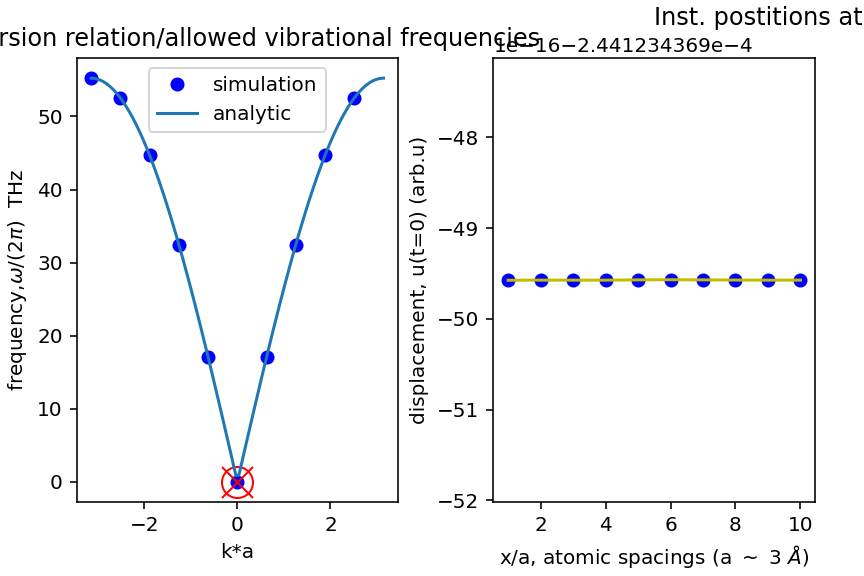

In [47]:
VariablesForSaveAnim = [0]*10

def save_animation(event):
    """Save the current animation with current widget values."""
    global VariablesForSaveAnim
    try:
        VariablesForSaveAnim = [
            N_w.value, gamma_w.value, bc, M1_w.value, M2_w.value,
            imp_enabled_w.value, Nimp_w.value, Mimp_w.value, ModeNr_w.value, bound_update()
        ]

        import json
        with open("VariablesForSaveAnim.json", "w") as f:
            json.dump(VariablesForSaveAnim, f, indent=2)

        subprocess.run(
            ["jupyter", "nbconvert", "--to", "notebook", "--execute", "AnimationSave.ipynb",
             "--output", "AnimationSave_executed.ipynb"],
            check=True
        )

        output_pane.object = "<b>Animation saved successfully!</b>"

    except Exception as e:
        output_pane.object = f"<b style='color:red;'>Error saving animation:</b><br>{e}"

save_anim_btn.on_click(save_animation)

masses_box = pn.Accordion(
    ("Masses", pn.Row(
        pn.Column("Mass 1 $M_1$ (u)", M1_w),
        pn.Column("Mass 2 $M_2$ (u)", M2_w, pn.pane.HTML("&nbsp;"), pn.Row(equalize_btn))
    )),
    ("Impurity", pn.Row(
        pn.Column("Mass of imp. (u)", Mimp_w),
        pn.Column("Atom nr. of imp.", Nimp_w),
        pn.Column("Impurity enable", imp_enabled_w)
    ))
)

mode_bc_box = pn.Row(
    pn.Column("Mode number", ModeNr_w),
    pn.Column("Boundary condition", bc),
    pn.Spacer(width=20),
    html_text
)

animation_controls = pn.Row(create_anim_btn, save_anim_btn)

"""
animation_panel = pn.Column(
    pn.Row(
        pn.Column("N of atoms", N_w),
        pn.Column("Force constant γ (N/m)", gamma_w)
    ),
    masses_box,
    mode_bc_box,
    animation_controls,
    output_pane
)

animation_panel.servable()
"""

# 1. Bind the 'update' function (the one you defined above) to your widgets
plot_pane = pn.bind(
    update, 
    N=N_w, 
    gamma=gamma_w, 
    bc=bc,           # Use the widget 'bc' as defined in your layout
    M1=M1_w, 
    M2=M2_w, 
    imp_enabled=imp_enabled_w, 
    Nimp=Nimp_w, 
    Mimp=Mimp_w, 
    ModeNr=ModeNr_w
)

# 2. Update the panel layout to include the plot_pane
animation_panel = pn.Column(
    pn.Row(
        pn.Column("N of atoms", N_w),
        pn.Column("Force constant γ (N/m)", gamma_w)
    ),
    masses_box,
    mode_bc_box,
    plot_pane,       # This renders the matplotlib figure from update()
    animation_controls,
    output_pane
)

# 3. Display the UI
animation_panel

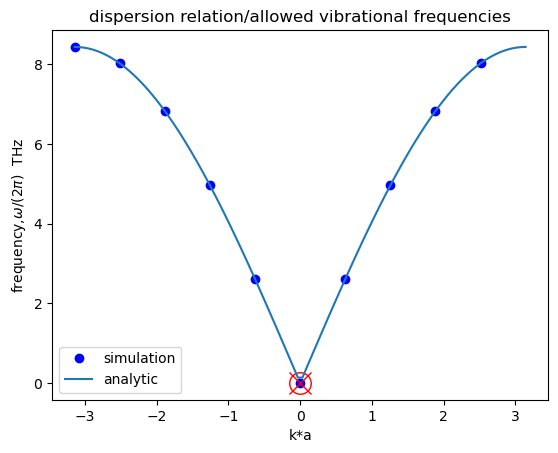

In [38]:
#fig
# display(OutWidg)
# outp